## Function Approximation
### Using the PSO algorithm to optimise the ANN's parameters

**1. Import Resources**

In [2]:
# import resources
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**2. Create Neural Network Class**

In [3]:
class NeuralNetwork:    
    def __init__(self, func, hiddenLayerNeurons, activation, inputList, outputList):
        self.func = func # name of the function to be optimized
        self.layerArch = list.copy(hiddenLayerNeurons) #list of neurons in the hidden layers
        self.activation = activation # name of the activation fuction
          
        self.inputArray = inputList # array of given input dataset
        self.outputArray = outputList # array of the desired output dataset
        #print(self.inputArray,self.outputArray)
        
        # adding input and output layers to the hidden neurons list
        self.inputOutputNeurons()
        
        # calculate number of weights
        self.nWeights = self.numWeights()
        
        # set activation function
        self.actFunc = self.functionSelection()
        
        # set indices at which weight matrix to be split for matrix multiplication
        self.splitIndices = self.splitIndices()
        
    def getANN_Hyperparameters(self):
        return [self.func, self.activation, self.layerArch]
        
    def getnWeights(self): # getter methonds for number of weights
        return self.nWeights
        
    def inputOutputNeurons(self): # a private method to neuralNetwork class
        # Set number neurons in the Input layer
        if self.func in ('XOR','Complex'):
            self.layerArch.insert(0,2) # XOR & Complex functions are based on two input variables
        else:
            self.layerArch.insert(0,1) # Linear, Cubic, Sine, Tanh functions are based on single input variable
       
        # Set number of neurons in the Output layer
        self.layerArch.append(1) # only single output value is expected from the fuction
        
    def numWeights(self):# a private method to neuralNetwork class
        n_weights = sum(self.layerArch[i]*self.layerArch[i+1] for i in range(len(self.layerArch)-1))
        return n_weights
    
    def functionSelection(self):# a private method to neuralNetwork class
        return activation_funcs[self.activation]
    
    def splitIndices(self):
        indices = []
        for i in range(len(self.layerArch)-1):
            indices.append(self.layerArch[i]*self.layerArch[i+1])

        splitIndices = []
        splitIndices.append(indices[0])
        for j in range(1,len(indices)-1):
            splitIndices.append(splitIndices[j-1] + indices[j])

        return splitIndices
    
    def forward(self, weights):
        
        # to do: check the length of list of weigths matches the number weights
        
        wArray = np.split(weights,self.splitIndices)
        #print("splitIndices",self.splitIndices)
        #print("wArray",wArray)
        #print("layerArch", self.layerArch)
        
        wMatrix=[]
        for i in range(0,len(self.layerArch)-1):
            wMatrix.append(wArray[i].reshape(self.layerArch[i+1],self.layerArch[i]))
        #print("wArray after reshape", wMatrix)
    
        desiredArray = np.copy(self.outputArray)
        predictArray = []
        
        for i in range(len(self.inputArray)):
            ih = self.inputArray[i].reshape(-1,1)
            for j in range(0,len(self.layerArch)-1):
                #print("wMatrix = ", wMatrix[j], "ih = ", ih)
                ih = np.matmul(wMatrix[j],ih)
            
                if j != (len(self.layerArch)-1):
                    ih = self.actFunc(ih)
            predictArray.append(ih)
            
        #print(len(desiredArray), len(predictArray))

        squeezePredict = np.squeeze(predictArray)

        mse = ((desiredArray - squeezePredict)**2).mean(axis = None)
       
        return mse.tolist()

**3. Create PSO Class**<br>
swarmsize - desired swarm size i.e. weight array<br>
$ \alpha \gets$ inertia weight i.e. proportion of velocity to be retained<br>
$ \beta \gets$ cognitive weight i.e. proportion of personal best to be retained<br>
$ \delta \gets$ social weight i.e. proportion of global best to be retained<br>
$ \epsilon \gets$ jump size of a particle (assumed 1 for this study)<br><br>
**Enforcing Boundaries**: boundaries are enforced by rebounding the position by reversing the inertia weight<br>

In [4]:
class ParticleSwarmOptimizer:    
    def __init__(self, swarm_size,pso_alpha, pso_beta, pso_delta, max_epochs, bound_max, bound_min, ann):
        # PSO parameters
        self.swarmSize = swarm_size # number of particles in swarm
        self.psoAlpha = pso_alpha # inertia weight
        self.psoBeta = pso_beta # cognitive weight 
        self.psoDelta = pso_delta # social weight
        self.maxEpochs = max_epochs # maximum number of iterations

        self.bound_max = bound_max
        self.bound_min = bound_min
        
        self.ann = ann # neural network
        self.dim = self.ann.getnWeights() # no. of weights in nurol network = dimension of particle
        
        self.swarm = [Particles(self.dim, self.ann) for i in range(swarm_size)] #create swarm with swarm_size particles
  
        # initialise global best position
        self.best_swarm_pos = np.ones(self.dim)
        
    def getSwarmSize(self):
        return self.swarmSize # no of particles in swarm
    
    def getFinalWeights(self):
        return self.best_swarm_pos
    
    def getPSO_Hyperparameters(self):
        return [self.swarmSize, self.psoAlpha, self.psoBeta, self.psoDelta, self.maxEpochs, self.bound_max, self.bound_min]
   
    def forward(self):
        #Data collection for report and graph
        report = '' # string for run report
        ann_hp = self.ann.getANN_Hyperparameters()
        report +=('Function:{}\nANN Hyperparameters: activation function {}, layer arch {}\n'.format(ann_hp[0],ann_hp[1],ann_hp[2]))
        report +=('PSO Hyperparameters: swarm size{}, inertia weight{}, cognitive weight{}, social weight{}, epochs{}'.format(self.swarmSize,self.psoAlpha,self.psoBeta,self.psoDelta,self.maxEpochs))
        report += '\n-------------------------------------------------------------------------------------'  
        report += '\n-------------------------------------------------------------------------------------\n'    
        data_Swarm_best = []
        data_Particle_current_best= []
        data_Particle_current_worst = []
        data_particle_current_average = []
        epoch_count =[]
        
        # initialise global best position and fittness/error
        best_swarm_err = 500
 
        epoch = 0
        while epoch < self.maxEpochs: # run until fixed number of iterations
            #data1= []
            #Update global best
            for ii in range(self.swarmSize): # for each particle in swarm/population
                
                position_ii = self.swarm[ii].getPosition()
                err_ii = (self.swarm[ii].getError())
  
                # update Global/swarm best error and position if found comparing fitness/error
                if err_ii < best_swarm_err:
                    best_swarm_err = err_ii
                    self.best_swarm_pos = position_ii
            #data1.extend([epoch+1,best_swarm_err])
            data_Swarm_best.append(best_swarm_err)
            epoch_count.append(epoch+1)
            
            #data2=[]
            pcb= 100 # setting to high error
            pcw= -100 # setting to low error
            pca=0
            for i in range(self.swarmSize): # for each particle in swarm/population

                # Gather information            
                position_i = self.swarm[i].getPosition()
                velocity_i = self.swarm[i].getVelocity()
                best_part_error_i = self.swarm[i].getBestPartErr()
                best_part_position_i = self.swarm[i].getBestPartPos()
                err_i = self.swarm[i].getError()
                
                report += ('epoch:{:03d} ,particle:{:02d}, par err:{:0.4f}, best part err:{:0.4f}, best swarm err:{:0.4f}'.
                      format(epoch+1, i+1, err_i, best_part_error_i ,best_swarm_err))+'\n'
                               
                #data2.extend([err_i,best_part_error_i])
                if pcb > err_i:
                    pcb = err_i
                if pcw < err_i:
                    pcw = err_i
                pca += err_i
                  
                
                # compute particle new velocity
                for k in range(self.dim): # for each dimension/weight in particle i
                    a = self.psoAlpha*velocity_i[k]
                    b = self.psoBeta*(best_part_position_i[k] - position_i[k])
                    c = self.psoDelta*(self.best_swarm_pos[k] - position_i[k])
                    velocity_i[k] = a+b+c
                    
                # compute particle new position as temp for checking bounds
                temp = np.add(position_i,velocity_i)
                
                # enforcing boundaries by rebounding particle with reversing the interia
                kk=0
                while kk < self.dim:
                    if temp[kk] >= self.bound_max or temp[kk] <= self.bound_min:
                        #position_f = (np.random.rand((self.dim)).astype(np.float32)-0.5)/2
                        #velocity_i = (np.random.rand((self.dim)).astype(np.float32)-0.5)/2
                        velocity_i[kk] = velocity_i[kk]- self.psoAlpha*velocity_i[k]
                        #print('weights breached at weights#',kk)
                    kk +=1
                
                # compute particle new position as temp
                position_f = np.add(position_i,velocity_i)

                # compute new fitness
                new_err = self.ann.forward(position_f)
                
                # update particle best error and position if found comparing fitness/error
                if new_err < best_part_error_i:
                    self.swarm[i].setBestPartErr(new_err)
                    self.swarm[i].setBestPartPos(position_f)
                
                # update particle class parameters              
                self.swarm[i].setPosition(position_f) # update particle position
                self.swarm[i].setVelocity(velocity_i) #update particle velocity
                self.swarm[i].setError(new_err) #update particle current error
                
                #print('epoch:{:03d} ,particle:{:02d}, par err:{:0.5f}, best part err:{:0.5f}, best swarm err:{:0.2f}'.
                      #format(epoch+1, i+1, new_err, self.swarm[i].getBestPartErr() ,best_swarm_err))
            pca = pca/self.swarmSize
            #data1.extend(data2)
            #self.data.append(data1)
            data_Particle_current_best.append(pcb)
            data_Particle_current_worst.append(pcw)
            data_particle_current_average.append(pca)
            report += '\n-------------------------------------------------------------------------------------\n'  
            epoch += 1
        return best_swarm_err, report, epoch_count,data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average

**4. Create Particles Class**

In [5]:
class Particles:
    def __init__(self, dim, ann):
        self.dim = dim
        self.ann =ann
        
        # initialise particle best position and velocity with random values 
        self.position = (np.random.rand((self.dim)).astype(np.float32)-0.5)/2 #current position; initialized with random
        self.velocity = (np.random.rand((self.dim)).astype(np.float32)-0.5)/2 #current velocity; initialized with random
        
        self.err = self.ann.forward(self.position)  #compute error for initial position
        
        self.best_part_pos = np.copy(self.position) # intialize particle best position as intial position
        self.best_part_err = self.err  #intialized particle best error as self error from intial position
        
    # getter methods    
    #def getDim(self): return self.dim
    def getPosition(self):return self.position
    def getVelocity(self):return self.velocity
    def getError(self):return self.err
    def getBestPartErr(self):return self.best_part_err
    def getBestPartPos(self):return self.best_part_pos

    
    # setter methods    
    def setPosition(self,pos):self.position = np.copy(pos)
    def setVelocity(self,vel):self.velocity = np.copy(vel)
    def setError(self,err): self.err = err
    def setBestPartErr(self,best_err): self.best_part_err = best_err
    def setBestPartPos(self,best_pos): self.best_part_pos = best_pos

**5. Create Helper function for passing activation function**

In [6]:
activation_funcs = {
    'Null': lambda x: x*0,
    'Sigmoid': lambda x: 1/(1 + np.exp(-x)),
    'Hyperbolic Tangent': lambda x: np.tanh(x),
    'Cosine': lambda x: np.cos(x),
    'Gaussian': lambda x: np.exp(-x**2/2),
        }

**6. Function to read data from the .txt file**

In [7]:
# load the training data from .txt file into a list
def read_data(func):
    txt_address = {'Linear':'Data/1in_linear.txt',
                   'Cubic':'Data/1in_cubic.txt',
                   'Sine':'Data/1in_sine.txt',
                   'TanH':'Data/1in_tanh.txt',
                   'XOR':'Data/2in_xor.txt',
                   'Complex':'Data/2in_complex.txt'}

    train_data_file = open(txt_address[func],'r')
    line_data = train_data_file.readlines()
    train_data_file.close()

    train_list = []
    for line in line_data:
        line = line.strip().split()
        for d in line:
            train_list.append(float(d))
        
    #check     
    #print(train_list)

    if func in ('XOR','Complex'):
        train_array = np.asarray(train_list, dtype=np.float32).reshape(-1,3)
        X,Y = train_array[:,0:2], train_array[:,-1]

    elif func in ('Linear', 'Cubic', 'Sine', 'TanH'):
        train_array = np.asarray(train_list, dtype=np.float32).reshape(-1,2)
        X,Y = train_array[:,0], train_array[:,-1]
    else:
        "error reading data"    
    #print(train_array)
    #print(X)
    #print(Y)
    
    return X,Y

### Optimized Hyperparameters

**1. Linear Function**

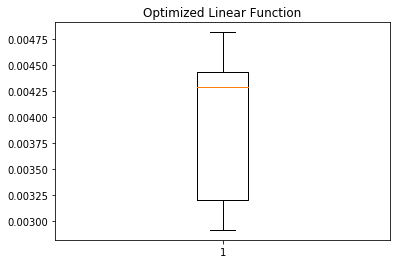

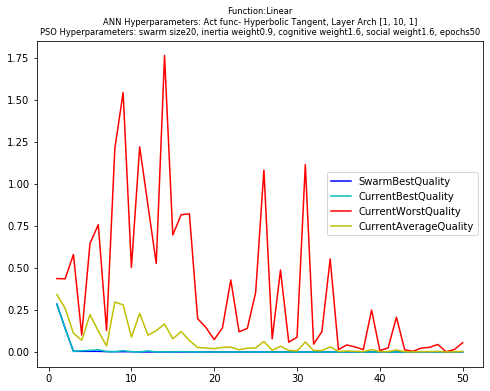

In [8]:
i_range = 1 #hyperparameters variant - Optimizatoin done in previous step
k_repeats = 15 #repeat each configuration sicne PSO is stocastic process

#Select Function:
func = 'Linear' #(Options: Linear, Cubic, Sine, TanH, XOR, Complex)

#Select ANN Hyperparameters
hidden_layer_neurons = [10]
activation = 'Hyperbolic Tangent' # (Options: Null, Sigmoid, Hyperbolic Tangent, Cosine, Gaussian)
X,Y = read_data(func)

#Select PSO Hyperparameters
swarm_size = 20
pso_alpha = 0.9 #0.729
pso_beta = 1.6 #1.49
pso_delta = 1.6 #1.49
max_epochs = 50
bound =100
bound_max = bound
bound_min = -bound


# initiate list of ann and pso objects
ann_list = []
pso_list= []

data_graph =[]
data_err_box =[]
for i in range(i_range):
    ann_list.append(NeuralNetwork(func, hidden_layer_neurons, activation, X,Y))
    
    box_temp = []
    graph_temp = []
    pso_list_temp = []
    for k in range(k_repeats):
        pso_list_temp.append(ParticleSwarmOptimizer(swarm_size,pso_alpha,pso_beta,pso_delta,max_epochs, bound_max, bound_min, ann_list[i]))
            
        best_swarm_err, report, epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average = pso_list_temp[k].forward()
            
        box_temp.append(best_swarm_err)
        #data_graph.append([best_swarm_err,report,epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average])
        graph_temp.append([best_swarm_err,report,epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average])

    data_err_box.append(box_temp)
    data_graph.append(graph_temp)
    pso_list.append(pso_list_temp)

#--------------------------------------------------------------------------------------#
#CREATE BOX PLOTS

fig,ax=plt.subplots(1,1)
ax.boxplot(data_err_box, 0, '')
ax.set_title('Optimized Linear Function')
plt.savefig('1.0 Optimized_Linear_box.png')

#--------------------------------------------------------------------------------------#
#CREATE RUNNING GRAPHS

pso_hp = []
ann_hp = []
plot_string = []

#Set Sub plots parameters
nx = 1
ny = i_range
dxs = 8
dys = 6
fig, axs = plt.subplots(ny, nx, sharey = True, figsize=(dxs*nx, dys*ny))
#fig.suptitle('QUALITIES',fontsize='x-large')

#set best weight
best_weight = []
#best_ann_hyperparm =[]
##

for ij in range(i_range):
    best_ind = np.argmin(data_err_box[ij])
    pso_hp.append(pso_list[ij][best_ind].getPSO_Hyperparameters())
    ann_hp.append(pso_list[ij][best_ind].ann.getANN_Hyperparameters())
    
    ## saving model
    best_weight.extend(pso_list[ij][best_ind].getFinalWeights())
    #best_ann_hyperparm.extend(pso_list[ij][best_ind].ann.getANN_Hyperparameters())
    np.savetxt("linear_weights.csv", best_weight, delimiter=",")
    #np.savetxt("Linear_ANN_hyperparm.csv",best_ann_hyperparm[2], delimiter=",")
    #np.savetxt("Linear_ANN_hyperparm",[best_ann_hyperparm[1]], newline=" ")
    ## 
    
    temp_string = 'Function:{}\nANN Hyperparameters: Act func- {}, Layer Arch {}\n'.format(ann_hp[ij][0],ann_hp[ij][1],ann_hp[ij][2])
    temp_string += 'PSO Hyperparameters: swarm size{}, inertia weight{}, cognitive weight{}, social weight{}, epochs{}'.format(pso_hp[ij][0],pso_hp[ij][1],pso_hp[ij][2],pso_hp[ij][3],pso_hp[ij][4])
    plot_string.append(temp_string)

    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][3], 'b', label='SwarmBestQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][4],'c', label='CurrentBestQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][5],'r', label='CurrentWorstQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][6],'y', label='CurrentAverageQuality')
    
    axs.legend(loc='center right', shadow=False, fontsize='medium')
    axs.set_title(plot_string[ij],fontsize='small')
    

plt.savefig('1.0 Optimized_Linear_graph.png')

#--------------------------------------------------------------------------------------#
#SAVING REPORT TO TXT
msg=''
for ii in range(i_range):
    for jj in range(k_repeats):
        msg += data_graph[ii][jj][1]
        msg += '/n'    
        
with open("1.0 Optimized_Linear_report.txt", "w") as text_file:
    text_file.write(msg)

**2. Cubic Function**

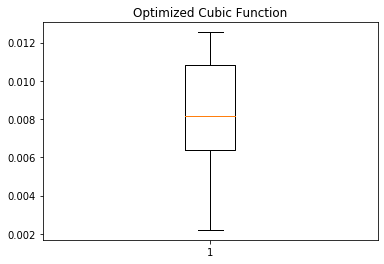

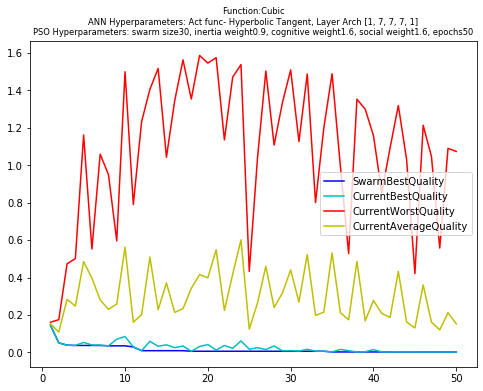

In [27]:
i_range = 1 #hyperparameters variant - Optimizatoin done in previous step
k_repeats = 15 #repeat each configuration sicne PSO is stocastic process

#Select Function:
func = 'Cubic' #(Options: Linear, Cubic, Sine, TanH, XOR, Complex)

#Select ANN Hyperparameters
hidden_layer_neurons = [7,7,7]
activation = 'Hyperbolic Tangent' # (Options: Null, Sigmoid, Hyperbolic Tangent, Cosine, Gaussian)
X,Y = read_data(func)

#Select PSO Hyperparameters
swarm_size = 30
pso_alpha = 0.9 #0.729
pso_beta = 1.6 #1.49
pso_delta = 1.6 #1.49
max_epochs = 50
bound =100
bound_max = bound
bound_min = -bound


# initiate list of ann and pso objects
ann_list = []
pso_list= []

data_graph =[]
data_err_box =[]
for i in range(i_range):
    ann_list.append(NeuralNetwork(func, hidden_layer_neurons, activation, X,Y))
    
    box_temp = []
    graph_temp = []
    pso_list_temp = []
    for k in range(k_repeats):
        pso_list_temp.append(ParticleSwarmOptimizer(swarm_size,pso_alpha,pso_beta,pso_delta,max_epochs, bound_max, bound_min, ann_list[i]))
            
        best_swarm_err, report, epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average = pso_list_temp[k].forward()
            
        box_temp.append(best_swarm_err)
        #data_graph.append([best_swarm_err,report,epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average])
        graph_temp.append([best_swarm_err,report,epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average])

    data_err_box.append(box_temp)
    data_graph.append(graph_temp)
    pso_list.append(pso_list_temp)

#--------------------------------------------------------------------------------------#
#CREATE BOX PLOTS

fig,ax=plt.subplots(1,1)
ax.boxplot(data_err_box, 0, '')
ax.set_title('Optimized Cubic Function')
plt.savefig('2.0 Optimized_Sigmoid_box.png')

#--------------------------------------------------------------------------------------#
#CREATE RUNNING GRAPHS

pso_hp = []
ann_hp = []
plot_string = []

#Set Sub plots parameters
nx = 1
ny = i_range
dxs = 8
dys = 6
fig, axs = plt.subplots(ny, nx, sharey = True, figsize=(dxs*nx, dys*ny))
#fig.suptitle('QUALITIES',fontsize='x-large')

#set best weight
best_weight = []
#best_ann_hyperparm =[]
##

for ij in range(i_range):
    best_ind = np.argmin(data_err_box[ij])
    pso_hp.append(pso_list[ij][best_ind].getPSO_Hyperparameters())
    ann_hp.append(pso_list[ij][best_ind].ann.getANN_Hyperparameters())
    
    ## saving model
    best_weight.extend(pso_list[ij][best_ind].getFinalWeights())
    #best_ann_hyperparm.extend(pso_list[ij][best_ind].ann.getANN_Hyperparameters())
    np.savetxt("cubic_weights.csv", best_weight, delimiter=",")
    #np.savetxt("Linear_ANN_hyperparm.csv",best_ann_hyperparm[2], delimiter=",")
    #np.savetxt("Linear_ANN_hyperparm",[best_ann_hyperparm[1]], newline=" ")
    ## 
    
    temp_string = 'Function:{}\nANN Hyperparameters: Act func- {}, Layer Arch {}\n'.format(ann_hp[ij][0],ann_hp[ij][1],ann_hp[ij][2])
    temp_string += 'PSO Hyperparameters: swarm size{}, inertia weight{}, cognitive weight{}, social weight{}, epochs{}'.format(pso_hp[ij][0],pso_hp[ij][1],pso_hp[ij][2],pso_hp[ij][3],pso_hp[ij][4])
    plot_string.append(temp_string)

    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][3], 'b', label='SwarmBestQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][4],'c', label='CurrentBestQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][5],'r', label='CurrentWorstQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][6],'y', label='CurrentAverageQuality')
    
    axs.legend(loc='center right', shadow=False, fontsize='medium')
    axs.set_title(plot_string[ij],fontsize='small')
    

plt.savefig('2.0 Optimized_Sigmoid_graphs.png')

#--------------------------------------------------------------------------------------#
#SAVING REPORT TO TXT
msg=''
for ii in range(i_range):
    for jj in range(k_repeats):
        msg += data_graph[ii][jj][1]
        msg += '/n'    
        
with open("2.0 Optimized_Sigmoid_report.txt", "w") as text_file:
    text_file.write(msg)

**3. Sine Function**

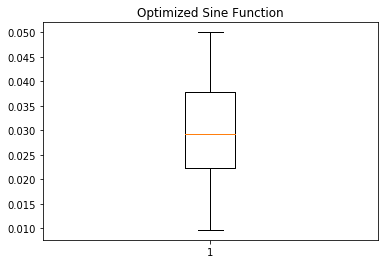

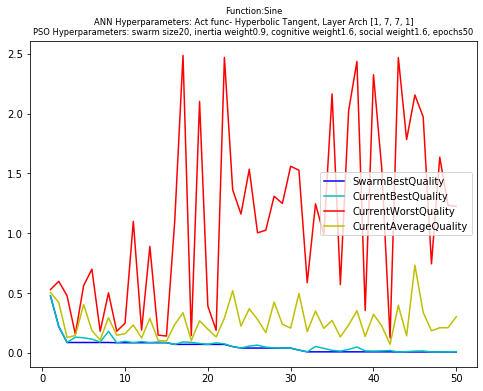

In [54]:
i_range = 1 #hyperparameters variant - Optimizatoin done in previous step
k_repeats = 15 #repeat each configuration sicne PSO is stocastic process

#Select Function:
func = 'Sine' #(Options: Linear, Cubic, Sine, TanH, XOR, Complex)

#Select ANN Hyperparameters
hidden_layer_neurons = [7,7]
activation = 'Hyperbolic Tangent' # (Options: Null, Sigmoid, Hyperbolic Tangent, Cosine, Gaussian)
X,Y = read_data(func)

#Select PSO Hyperparameters
swarm_size = 20
pso_alpha = 0.9 #0.729
pso_beta = 1.6 #1.49
pso_delta = 1.6 #1.49
max_epochs = 50
bound =50
bound_max = bound
bound_min = -bound


# initiate list of ann and pso objects
ann_list = []
pso_list= []

data_graph =[]
data_err_box =[]
for i in range(i_range):
    ann_list.append(NeuralNetwork(func, hidden_layer_neurons, activation, X,Y))
    
    box_temp = []
    graph_temp = []
    pso_list_temp = []
    for k in range(k_repeats):
        pso_list_temp.append(ParticleSwarmOptimizer(swarm_size,pso_alpha,pso_beta,pso_delta,max_epochs, bound_max, bound_min, ann_list[i]))
            
        best_swarm_err, report, epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average = pso_list_temp[k].forward()
            
        box_temp.append(best_swarm_err)
        #data_graph.append([best_swarm_err,report,epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average])
        graph_temp.append([best_swarm_err,report,epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average])

    data_err_box.append(box_temp)
    data_graph.append(graph_temp)
    pso_list.append(pso_list_temp)

#--------------------------------------------------------------------------------------#
#CREATE BOX PLOTS

fig,ax=plt.subplots(1,1)
ax.boxplot(data_err_box, 0, '')
ax.set_title('Optimized Sine Function')
plt.savefig('3.0 Optimized_Sine_box.png')

#--------------------------------------------------------------------------------------#
#CREATE RUNNING GRAPHS

pso_hp = []
ann_hp = []
plot_string = []

#Set Sub plots parameters
nx = 1
ny = i_range
dxs = 8
dys = 6
fig, axs = plt.subplots(ny, nx, sharey = True, figsize=(dxs*nx, dys*ny))
#fig.suptitle('QUALITIES',fontsize='x-large')

#set best weight
best_weight = []
#best_ann_hyperparm =[]
##

for ij in range(i_range):
    best_ind = np.argmin(data_err_box[ij])
    pso_hp.append(pso_list[ij][best_ind].getPSO_Hyperparameters())
    ann_hp.append(pso_list[ij][best_ind].ann.getANN_Hyperparameters())
    
    ## saving model
    best_weight.extend(pso_list[ij][best_ind].getFinalWeights())
    #best_ann_hyperparm.extend(pso_list[ij][best_ind].ann.getANN_Hyperparameters())
    np.savetxt("sine_weights.csv", best_weight, delimiter=",")
    #np.savetxt("Linear_ANN_hyperparm.csv",best_ann_hyperparm[2], delimiter=",")
    #np.savetxt("Linear_ANN_hyperparm",[best_ann_hyperparm[1]], newline=" ")
    ## 
    
    temp_string = 'Function:{}\nANN Hyperparameters: Act func- {}, Layer Arch {}\n'.format(ann_hp[ij][0],ann_hp[ij][1],ann_hp[ij][2])
    temp_string += 'PSO Hyperparameters: swarm size{}, inertia weight{}, cognitive weight{}, social weight{}, epochs{}'.format(pso_hp[ij][0],pso_hp[ij][1],pso_hp[ij][2],pso_hp[ij][3],pso_hp[ij][4])
    plot_string.append(temp_string)

    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][3], 'b', label='SwarmBestQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][4],'c', label='CurrentBestQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][5],'r', label='CurrentWorstQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][6],'y', label='CurrentAverageQuality')
    
    axs.legend(loc='center right', shadow=False, fontsize='medium')
    axs.set_title(plot_string[ij],fontsize='small')
    

plt.savefig('3.0 Optimized_Sine_graphs.png')

#--------------------------------------------------------------------------------------#
#SAVING REPORT TO TXT
msg=''
for ii in range(i_range):
    for jj in range(k_repeats):
        msg += data_graph[ii][jj][1]
        msg += '/n'    
        
with open("3.0 Optimized_Sine_report.txt", "w") as text_file:
    text_file.write(msg)

**4. TanH Function**

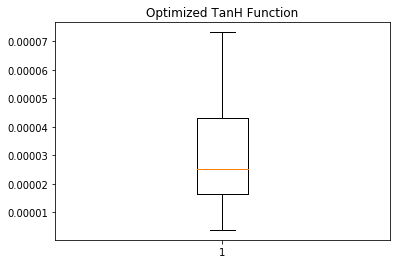

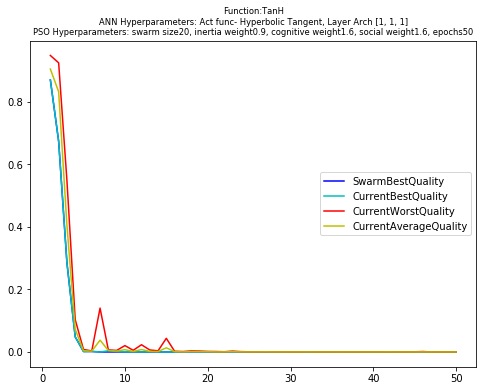

In [30]:
i_range = 1 #hyperparameters variant - Optimizatoin done in previous step
k_repeats = 15 #repeat each configuration sicne PSO is stocastic process

#Select Function:
func = 'TanH' #(Options: Linear, Cubic, Sine, TanH, XOR, Complex)

#Select ANN Hyperparameters
hidden_layer_neurons = [1]
activation = 'Hyperbolic Tangent' # (Options: Null, Sigmoid, Hyperbolic Tangent, Cosine, Gaussian)
X,Y = read_data(func)

#Select PSO Hyperparameters
swarm_size = 20
pso_alpha = 0.9 #0.729
pso_beta = 1.6 #1.49
pso_delta = 1.6 #1.49
max_epochs = 50
bound =50
bound_max = bound
bound_min = -bound


# initiate list of ann and pso objects
ann_list = []
pso_list= []

data_graph =[]
data_err_box =[]
for i in range(i_range):
    ann_list.append(NeuralNetwork(func, hidden_layer_neurons, activation, X,Y))
    
    box_temp = []
    graph_temp = []
    pso_list_temp = []
    for k in range(k_repeats):
        pso_list_temp.append(ParticleSwarmOptimizer(swarm_size,pso_alpha,pso_beta,pso_delta,max_epochs, bound_max, bound_min, ann_list[i]))
            
        best_swarm_err, report, epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average = pso_list_temp[k].forward()
            
        box_temp.append(best_swarm_err)
        #data_graph.append([best_swarm_err,report,epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average])
        graph_temp.append([best_swarm_err,report,epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average])

    data_err_box.append(box_temp)
    data_graph.append(graph_temp)
    pso_list.append(pso_list_temp)

#--------------------------------------------------------------------------------------#
#CREATE BOX PLOTS

fig,ax=plt.subplots(1,1)
ax.boxplot(data_err_box, 0, '')
ax.set_title('Optimized TanH Function')
plt.savefig('4.0 Optimized_TanH_size_box.png')

#--------------------------------------------------------------------------------------#
#CREATE RUNNING GRAPHS

pso_hp = []
ann_hp = []
plot_string = []

#Set Sub plots parameters
nx = 1
ny = i_range
dxs = 8
dys = 6
fig, axs = plt.subplots(ny, nx, sharey = True, figsize=(dxs*nx, dys*ny))
#fig.suptitle('QUALITIES',fontsize='x-large')

#set best weight
best_weight = []
#best_ann_hyperparm =[]
##

for ij in range(i_range):
    best_ind = np.argmin(data_err_box[ij])
    pso_hp.append(pso_list[ij][best_ind].getPSO_Hyperparameters())
    ann_hp.append(pso_list[ij][best_ind].ann.getANN_Hyperparameters())
    
    ## saving model
    best_weight.extend(pso_list[ij][best_ind].getFinalWeights())
    #best_ann_hyperparm.extend(pso_list[ij][best_ind].ann.getANN_Hyperparameters())
    np.savetxt("tanh_weights.csv", best_weight, delimiter=",")
    #np.savetxt("Linear_ANN_hyperparm.csv",best_ann_hyperparm[2], delimiter=",")
    #np.savetxt("Linear_ANN_hyperparm",[best_ann_hyperparm[1]], newline=" ")
    ## 
    
    temp_string = 'Function:{}\nANN Hyperparameters: Act func- {}, Layer Arch {}\n'.format(ann_hp[ij][0],ann_hp[ij][1],ann_hp[ij][2])
    temp_string += 'PSO Hyperparameters: swarm size{}, inertia weight{}, cognitive weight{}, social weight{}, epochs{}'.format(pso_hp[ij][0],pso_hp[ij][1],pso_hp[ij][2],pso_hp[ij][3],pso_hp[ij][4])
    plot_string.append(temp_string)

    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][3], 'b', label='SwarmBestQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][4],'c', label='CurrentBestQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][5],'r', label='CurrentWorstQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][6],'y', label='CurrentAverageQuality')
    
    axs.legend(loc='center right', shadow=False, fontsize='medium')
    axs.set_title(plot_string[ij],fontsize='small')
    
plt.savefig('4.0 Optimized_TanH_graphs.png')

#--------------------------------------------------------------------------------------#
#SAVING REPORT TO TXT
msg=''
for ii in range(i_range):
    for jj in range(k_repeats):
        msg += data_graph[ii][jj][1]
        msg += '/n'    
        
with open("4.0 Optimized_TanH_report.txt", "w") as text_file:
    text_file.write(msg)

**5. XOR Function**

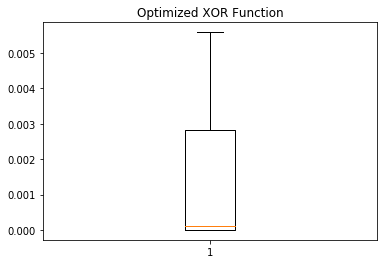

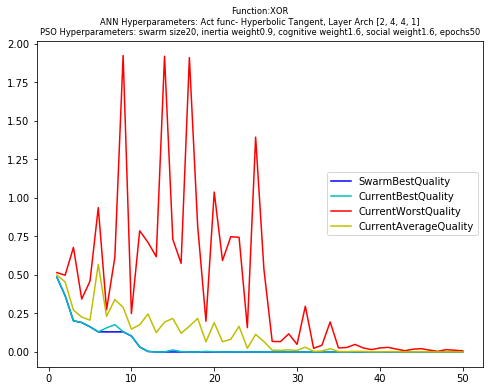

In [40]:
i_range = 1 #hyperparameters variant - Optimizatoin done in previous step
k_repeats = 20 #repeat each configuration sicne PSO is stocastic process

#Select Function:
func = 'XOR' #(Options: Linear, Cubic, Sine, TanH, XOR, Complex)

#Select ANN Hyperparameters
hidden_layer_neurons = [4,4]
activation = 'Hyperbolic Tangent' # (Options: Null, Sigmoid, Hyperbolic Tangent, Cosine, Gaussian)
X,Y = read_data(func)

#Select PSO Hyperparameters
swarm_size = 20
pso_alpha = 0.9 #0.729
pso_beta = 1.6 #1.49
pso_delta = 1.6 #1.49
max_epochs = 50
bound =50
bound_max = bound
bound_min = -bound


# initiate list of ann and pso objects
ann_list = []
pso_list= []

data_graph =[]
data_err_box =[]
for i in range(i_range):
    ann_list.append(NeuralNetwork(func, hidden_layer_neurons, activation, X,Y))
    
    box_temp = []
    graph_temp = []
    pso_list_temp = []
    for k in range(k_repeats):
        pso_list_temp.append(ParticleSwarmOptimizer(swarm_size,pso_alpha,pso_beta,pso_delta,max_epochs, bound_max, bound_min, ann_list[i]))
            
        best_swarm_err, report, epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average = pso_list_temp[k].forward()
            
        box_temp.append(best_swarm_err)
        #data_graph.append([best_swarm_err,report,epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average])
        graph_temp.append([best_swarm_err,report,epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average])

    data_err_box.append(box_temp)
    data_graph.append(graph_temp)
    pso_list.append(pso_list_temp)

#--------------------------------------------------------------------------------------#
#CREATE BOX PLOTS

fig,ax=plt.subplots(1,1)
ax.boxplot(data_err_box, 0, '')
ax.set_title('Optimized XOR Function')
plt.savefig('5.0 Optimized_XOR_box.png')

#--------------------------------------------------------------------------------------#
#CREATE RUNNING GRAPHS

pso_hp = []
ann_hp = []
plot_string = []

#Set Sub plots parameters
nx = 1
ny = i_range
dxs = 8
dys = 6
fig, axs = plt.subplots(ny, nx, sharey = True, figsize=(dxs*nx, dys*ny))
#fig.suptitle('QUALITIES',fontsize='x-large')

#set best weight
best_weight = []
#best_ann_hyperparm =[]
##

for ij in range(i_range):
    best_ind = np.argmin(data_err_box[ij])
    pso_hp.append(pso_list[ij][best_ind].getPSO_Hyperparameters())
    ann_hp.append(pso_list[ij][best_ind].ann.getANN_Hyperparameters())
    
    ## saving model
    best_weight.extend(pso_list[ij][best_ind].getFinalWeights())
    #best_ann_hyperparm.extend(pso_list[ij][best_ind].ann.getANN_Hyperparameters())
    np.savetxt("xor_weights.csv", best_weight, delimiter=",")
    #np.savetxt("Linear_ANN_hyperparm.csv",best_ann_hyperparm[2], delimiter=",")
    #np.savetxt("Linear_ANN_hyperparm",[best_ann_hyperparm[1]], newline=" ")
    ## 
    
    temp_string = 'Function:{}\nANN Hyperparameters: Act func- {}, Layer Arch {}\n'.format(ann_hp[ij][0],ann_hp[ij][1],ann_hp[ij][2])
    temp_string += 'PSO Hyperparameters: swarm size{}, inertia weight{}, cognitive weight{}, social weight{}, epochs{}'.format(pso_hp[ij][0],pso_hp[ij][1],pso_hp[ij][2],pso_hp[ij][3],pso_hp[ij][4])
    plot_string.append(temp_string)

    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][3], 'b', label='SwarmBestQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][4],'c', label='CurrentBestQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][5],'r', label='CurrentWorstQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][6],'y', label='CurrentAverageQuality')
    
    axs.legend(loc='center right', shadow=False, fontsize='medium')
    axs.set_title(plot_string[ij],fontsize='small')
    
plt.savefig('5.0 Optimized_XOR_graphs.png')

#--------------------------------------------------------------------------------------#
#SAVING REPORT TO TXT
msg=''
for ii in range(i_range):
    for jj in range(k_repeats):
        msg += data_graph[ii][jj][1]
        msg += '/n'    
        
with open("5.0 Optimized_XOR_report.txt", "w") as text_file:
    text_file.write(msg)

**6. Complex Function**

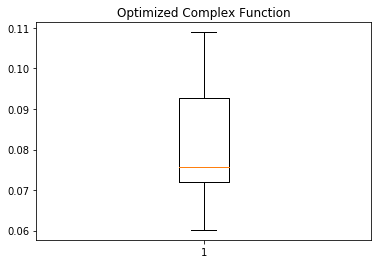

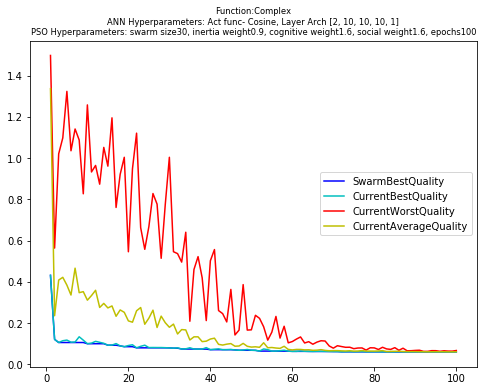

In [49]:
i_range = 1 #hyperparameters variant - Optimizatoin done in previous step
k_repeats = 15 #repeat each configuration sicne PSO is stocastic process

#Select Function:
func = 'Complex' #(Options: Linear, Cubic, Sine, TanH, XOR, Complex)

#Select ANN Hyperparameters
hidden_layer_neurons = [10,10,10]
activation = 'Cosine' # (Options: Null, Sigmoid, Hyperbolic Tangent, Cosine, Gaussian)
X,Y = read_data(func)

#Select PSO Hyperparameters
swarm_size = 30
pso_alpha = 0.9 #0.729
pso_beta = 1.6 #1.49
pso_delta = 1.6 #1.49
max_epochs = 100
bound =100
bound_max = bound
bound_min = -bound


# initiate list of ann and pso objects
ann_list = []
pso_list= []

data_graph =[]
data_err_box =[]
for i in range(i_range):
    ann_list.append(NeuralNetwork(func, hidden_layer_neurons, activation, X,Y))
    
    box_temp = []
    graph_temp = []
    pso_list_temp = []
    for k in range(k_repeats):
        pso_list_temp.append(ParticleSwarmOptimizer(swarm_size,pso_alpha,pso_beta,pso_delta,max_epochs, bound_max, bound_min, ann_list[i]))
            
        best_swarm_err, report, epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average = pso_list_temp[k].forward()
            
        box_temp.append(best_swarm_err)
        #data_graph.append([best_swarm_err,report,epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average])
        graph_temp.append([best_swarm_err,report,epoch_count, data_Swarm_best, data_Particle_current_best,data_Particle_current_worst,data_particle_current_average])

    data_err_box.append(box_temp)
    data_graph.append(graph_temp)
    pso_list.append(pso_list_temp)

#--------------------------------------------------------------------------------------#
#CREATE BOX PLOTS

fig,ax=plt.subplots(1,1)
ax.boxplot(data_err_box, 0, '')
ax.set_title('Optimized Complex Function')
plt.savefig('6.0 Optimized_Complex_box.png')

#--------------------------------------------------------------------------------------#
#CREATE RUNNING GRAPHS

pso_hp = []
ann_hp = []
plot_string = []

#Set Sub plots parameters
nx = 1
ny = i_range
dxs = 8
dys = 6
fig, axs = plt.subplots(ny, nx, sharey = True, figsize=(dxs*nx, dys*ny))
#fig.suptitle('QUALITIES',fontsize='x-large')

#set best weight
best_weight = []
#best_ann_hyperparm =[]
##

for ij in range(i_range):
    best_ind = np.argmin(data_err_box[ij])
    pso_hp.append(pso_list[ij][best_ind].getPSO_Hyperparameters())
    ann_hp.append(pso_list[ij][best_ind].ann.getANN_Hyperparameters())
    
    ## saving model
    best_weight.extend(pso_list[ij][best_ind].getFinalWeights())
    #best_ann_hyperparm.extend(pso_list[ij][best_ind].ann.getANN_Hyperparameters())
    np.savetxt("complex_weights.csv", best_weight, delimiter=",")
    #np.savetxt("Linear_ANN_hyperparm.csv",best_ann_hyperparm[2], delimiter=",")
    #np.savetxt("Linear_ANN_hyperparm",[best_ann_hyperparm[1]], newline=" ")
    ## 
    
    temp_string = 'Function:{}\nANN Hyperparameters: Act func- {}, Layer Arch {}\n'.format(ann_hp[ij][0],ann_hp[ij][1],ann_hp[ij][2])
    temp_string += 'PSO Hyperparameters: swarm size{}, inertia weight{}, cognitive weight{}, social weight{}, epochs{}'.format(pso_hp[ij][0],pso_hp[ij][1],pso_hp[ij][2],pso_hp[ij][3],pso_hp[ij][4])
    plot_string.append(temp_string)

    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][3], 'b', label='SwarmBestQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][4],'c', label='CurrentBestQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][5],'r', label='CurrentWorstQuality')
    axs.plot(data_graph[ij][best_ind][2], data_graph[ij][best_ind][6],'y', label='CurrentAverageQuality')
    
    axs.legend(loc='center right', shadow=False, fontsize='medium')
    axs.set_title(plot_string[ij],fontsize='small')
    
plt.savefig('6.0 Optimized_Complex_graphs.png')

#--------------------------------------------------------------------------------------#
#SAVING REPORT TO TXT
msg=''
for ii in range(i_range):
    for jj in range(k_repeats):
        msg += data_graph[ii][jj][1]
        msg += '/n'    
        
with open("6.0 Optimized_Complex_report.txt", "w") as text_file:
    text_file.write(msg)